# [House Prices data from Kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques)

Notebook inspired by [tutorials](https://www.kaggle.com/c/house-prices-advanced-regression-techniques#tutorials) and [other notebooks](https://github.com/IvanFerrante92/House-Price-Predictions---Kaggle-Competitions).

In [1]:
import re
from itertools import combinations
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd
from pandas.api.types import CategoricalDtype
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn import ensemble 
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error, mean_squared_log_error
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import RobustScaler
import seaborn as sns
sns.set()
%matplotlib inline

HOUSING_DATA_PATH = Path("datasets/housing")

A lot of variables are categorical. Extract a dict of categorical dtypes from data_description.txt. Reserve order to have best == higher.

In [2]:
def category(group):
    return CategoricalDtype(categories=reversed(re.findall(r'([a-zA-Z0-9.&]+).+$', group, re.MULTILINE)),
                                ordered=True)

def extract_cat(descr_string):
    """Extract categories from data_description."""
    return {m.group(1): category(m.group(2))
              for m in re.finditer(r'^(\w+).*\n[ \t]*\n((?:[ \t]+.+\n)+)', descr_string, re.MULTILINE)}

with open(HOUSING_DATA_PATH / "data_description.txt") as f:
    col_types_dict = extract_cat(f.read())

col_types_dict

{'Alley': CategoricalDtype(categories=['NA', 'Pave', 'Grvl'], ordered=True),
 'BldgType': CategoricalDtype(categories=['TwnhsI', 'TwnhsE', 'Duplx', '2FmCon', '1Fam'], ordered=True),
 'BsmtCond': CategoricalDtype(categories=['NA', 'Po', 'Fa', 'TA', 'Gd', 'Ex'], ordered=True),
 'BsmtExposure': CategoricalDtype(categories=['NA', 'No', 'Mn', 'Av', 'Gd'], ordered=True),
 'BsmtFinType1': CategoricalDtype(categories=['NA', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'], ordered=True),
 'BsmtFinType2': CategoricalDtype(categories=['NA', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'], ordered=True),
 'BsmtQual': CategoricalDtype(categories=['NA', 'Po', 'Fa', 'TA', 'Gd', 'Ex'], ordered=True),
 'CentralAir': CategoricalDtype(categories=['Y', 'N'], ordered=True),
 'Condition1': CategoricalDtype(categories=['RRAe', 'RRNe', 'PosA', 'PosN', 'RRAn', 'RRNn', 'Norm',
                   'Feedr', 'Artery'],
                  ordered=True),
 'Condition2': CategoricalDtype(categories=['RRAe', 'RRNe', 'PosA', 'PosN', 

Read data before adding types.

In [3]:
def load_housing_data(path=HOUSING_DATA_PATH, **args):
    for name in ("train", "test"):
        csv_path = path / f"{name}.csv"
        yield pd.read_csv(csv_path, **args)

train, test = load_housing_data()
dataset = pd.concat([train, test])
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 0 to 1458
Data columns (total 81 columns):
1stFlrSF         2919 non-null int64
2ndFlrSF         2919 non-null int64
3SsnPorch        2919 non-null int64
Alley            198 non-null object
BedroomAbvGr     2919 non-null int64
BldgType         2919 non-null object
BsmtCond         2837 non-null object
BsmtExposure     2837 non-null object
BsmtFinSF1       2918 non-null float64
BsmtFinSF2       2918 non-null float64
BsmtFinType1     2840 non-null object
BsmtFinType2     2839 non-null object
BsmtFullBath     2917 non-null float64
BsmtHalfBath     2917 non-null float64
BsmtQual         2838 non-null object
BsmtUnfSF        2918 non-null float64
CentralAir       2919 non-null object
Condition1       2919 non-null object
Condition2       2919 non-null object
Electrical       2918 non-null object
EnclosedPorch    2919 non-null int64
ExterCond        2919 non-null object
ExterQual        2919 non-null object
Exterior1st      291

A few categories from data_description.txt need to be adjusted to real values in data.

In [4]:
def find_enc_errors(df):
    """Find potential encoding errors in DataFrame with respect to data_description."""
    new_categories = {}
    for col in df:
        cat_descr_index = col_types_dict[col].categories
        cat_df = df[col].astype('category')
        cat_df = cat_df.cat.as_ordered().dtype
        cat_df_index = cat_df.categories
        diff = cat_df_index.difference(cat_descr_index)
        if diff.any():
            print(f"{col}\nin data: {cat_df_index.tolist()}\ndescription: {cat_descr_index.tolist()}\ndiff: {diff.tolist()}\n".format(col, diff))
            new_categories[col] = cat_df
    return new_categories

new_categories = find_enc_errors(dataset.select_dtypes(exclude=['int64', 'float64']))
col_types_dict_mod = col_types_dict.copy()
col_types_dict_mod.update(new_categories)

BldgType
in data: ['1Fam', '2fmCon', 'Duplex', 'Twnhs', 'TwnhsE']
description: ['TwnhsI', 'TwnhsE', 'Duplx', '2FmCon', '1Fam']
diff: ['2fmCon', 'Duplex', 'Twnhs']

Exterior1st
in data: ['AsbShng', 'AsphShn', 'BrkComm', 'BrkFace', 'CBlock', 'CemntBd', 'HdBoard', 'ImStucc', 'MetalSd', 'Plywood', 'Stone', 'Stucco', 'VinylSd', 'Wd Sdng', 'WdShing']
description: ['WdShing', 'Wd', 'VinylSd', 'Stucco', 'Stone', 'PreCast', 'Plywood', 'Other', 'MetalSd', 'ImStucc', 'HdBoard', 'CemntBd', 'CBlock', 'BrkFace', 'BrkComm', 'AsphShn', 'AsbShng']
diff: ['Wd Sdng']

Exterior2nd
in data: ['AsbShng', 'AsphShn', 'Brk Cmn', 'BrkFace', 'CBlock', 'CmentBd', 'HdBoard', 'ImStucc', 'MetalSd', 'Other', 'Plywood', 'Stone', 'Stucco', 'VinylSd', 'Wd Sdng', 'Wd Shng']
description: ['WdShing', 'Wd', 'VinylSd', 'Stucco', 'Stone', 'PreCast', 'Plywood', 'Other', 'MetalSd', 'ImStucc', 'HdBoard', 'CemntBd', 'CBlock', 'BrkFace', 'BrkComm', 'AsphShn', 'AsbShng']
diff: ['Brk Cmn', 'CmentBd', 'Wd Sdng', 'Wd Shng']

MSZoning
i

A few categories have 'NA' as values: don't treat them as missing.

In [5]:
NA_in_cats = {c: ['' if v.categories[0] == 'NA' else 'NA'] for c, v in col_types_dict_mod.items()}
train, test = load_housing_data(dtype=col_types_dict_mod, keep_default_na=False, na_values=NA_in_cats)
dataset = pd.concat([train.drop('SalePrice', axis=1), test])
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 0 to 1458
Data columns (total 80 columns):
Id               2919 non-null int64
MSSubClass       2919 non-null category
MSZoning         2915 non-null category
LotFrontage      2433 non-null float64
LotArea          2919 non-null int64
Street           2919 non-null category
Alley            2919 non-null category
LotShape         2919 non-null category
LandContour      2919 non-null category
Utilities        2917 non-null category
LotConfig        2919 non-null category
LandSlope        2919 non-null category
Neighborhood     2919 non-null category
Condition1       2919 non-null category
Condition2       2919 non-null category
BldgType         2919 non-null category
HouseStyle       2919 non-null category
OverallQual      2919 non-null category
OverallCond      2919 non-null category
YearBuilt        2919 non-null int64
YearRemodAdd     2919 non-null int64
RoofStyle        2919 non-null category
RoofMatl         2919 non-

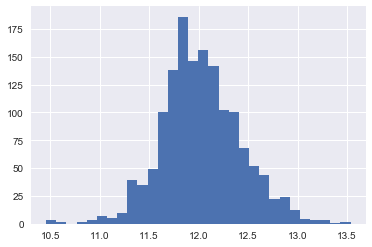

In [6]:
log_prices = np.log(train['SalePrice'])
log_prices.hist(bins=30);

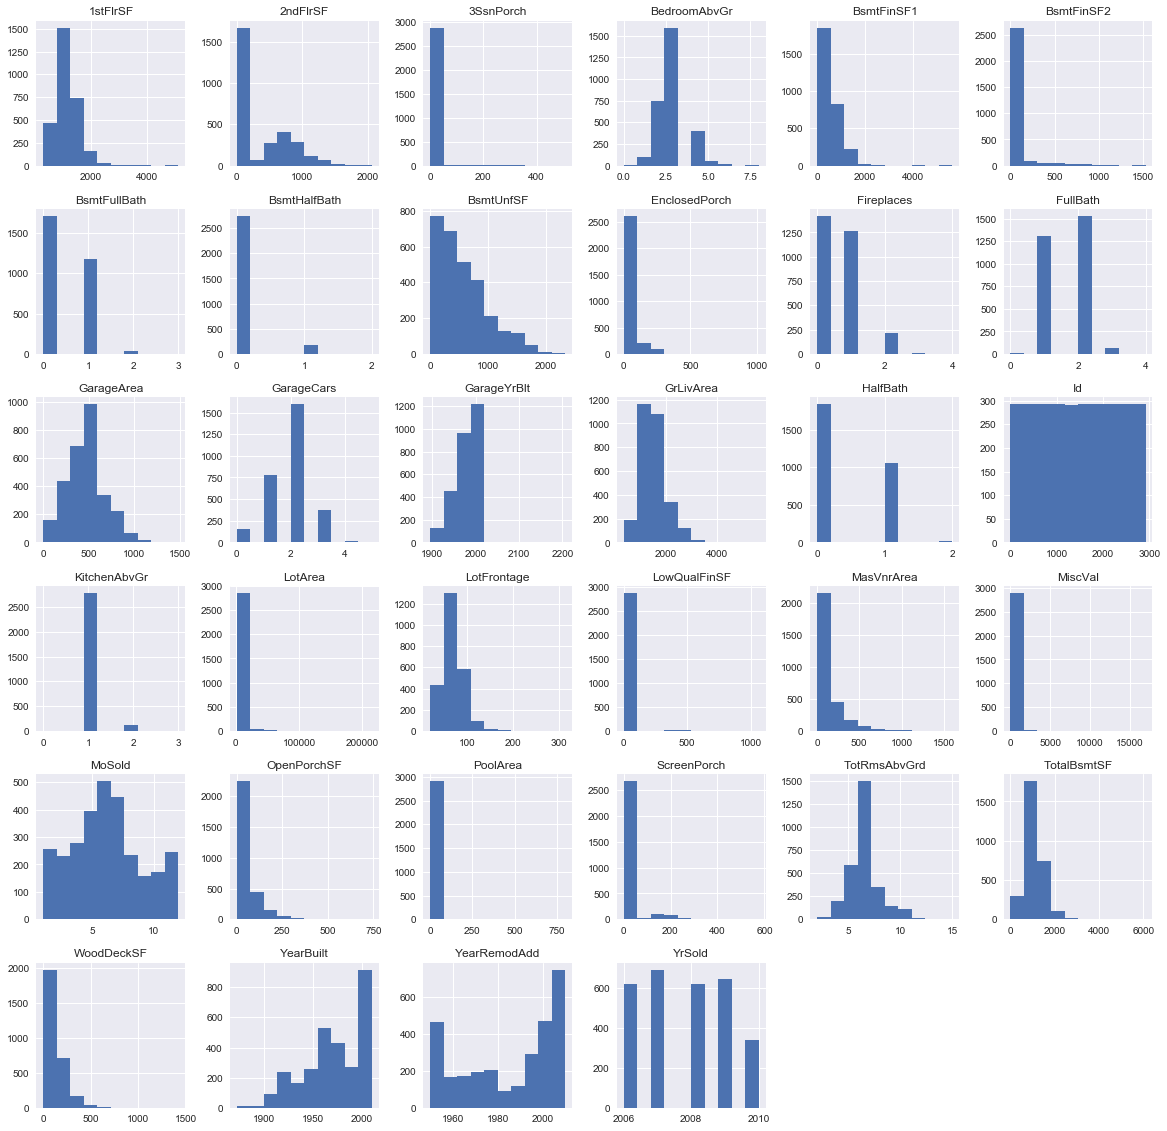

In [7]:
dataset.hist(figsize=(20,20));

*Todo* Interactive graphics to select points with [`Bokeh`](http://bokeh.pydata.org/en/latest/).

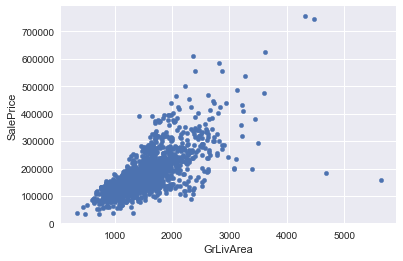

In [8]:
train.plot.scatter(x='GrLivArea', y='SalePrice')

Create dummy variables to neutralize 2 outliers on the bottom right.

In [9]:
outliers_ids = train[(train.GrLivArea > 4000) & (train.SalePrice < 500000)].Id.tolist()
outliers_ids

[524, 1299]

Missing values

In [10]:
def missing_frac(df):
    m = df.isnull().sum()
    return m[m > 0].sort_values(ascending=False)

missing = pd.concat({'train': missing_frac(train), 'test': missing_frac(test)}, axis=1)
missing_cols = missing.index
missing

,test,train
BsmtFinSF1,1.0,NaN
BsmtFinSF2,1.0,NaN
BsmtFullBath,2.0,NaN
BsmtHalfBath,2.0,NaN
BsmtUnfSF,1.0,NaN
Electrical,NaN,1.0
Exterior1st,1.0,NaN
Exterior2nd,1.0,NaN
Functional,2.0,NaN
GarageArea,1.0,NaN


In [11]:
def encode(df, onehot=True, columns=None):
    df = pd.get_dummies(df, drop_first=True, columns=columns) if onehot else df.copy()
    cols = df.select_dtypes(include=['category']).columns
    df[cols] = df[cols].apply(lambda s: s.cat.codes)
    return df
    
def impute(df, cols_dict):
    strategies = {'most_frequent': lambda s: s.value_counts().index[0],
                  'median': lambda s: s.median(),
                  'none': None}
    return df.fillna({k: strategies[v](df[k]) for k, v in cols_dict.items()})

def has(s, threshold=100):
    counts = s.value_counts()
    return counts.index[0] == 0 and counts[0] > threshold

def interact_dict(interact_cols):
    d = {}
    for col in interact_cols:
        group = [c for c in housing_cols if col in c]
        for a, b in combinations(group, 2):
            newcol = '{}_{}{}'.format(col, a.replace(col, ''), b.replace(col, ''))
            d[newcol] = lambda df : df[a] * df[b]
    return d

cols = dataset.columns
cat_cols = dataset.select_dtypes(include=['category']).columns
num_cols = dataset.select_dtypes(include=['int64', 'float64']).columns
fill_strats = {k: 'most_frequent' for k in cat_cols}
fill_strats.update({k: 'median' for k in num_cols})
for c in ['BsmtUnfSF', 'TotalBsmtSF', 'GarageCars', 'BsmtFinSF1',
          'BsmtFinSF2', 'GarageArea']:
    fill_strats[c] = 'most_frequent'
interact_cols = ['Bsmt', 'Overall', 'Exter', 'Fire', 'Garage', 'Porch']
has_cols = {f"Has_{col}": lambda df: df[col] > 0 for col in cols if has(dataset[col])}
id_dummies = {f"Id_{nid}": lambda df: df.Id == nid for nid in outliers_ids}
enc_dummies = ['MiscFeature', 'Alley', 'Fence', 'GarageType',
               'MasVnrType', 'MSZoning', 'Functional', 'Electrical',
               'Exterior1st', 'Exterior2nd', 'SaleType', 'MSSubClass', 
               'BldgType', 'CentralAir', 'Condition1', 'Condition2', 'ExterCond',
               'ExterQual', 'Foundation', 'Heating', 'HouseStyle',
               'LandContour', 'LandSlope', 'LotConfig', 'LotShape', 'Neighborhood',
               'PavedDrive', 'RoofMatl', 'RoofStyle', 'SaleCondition', 'Street']

poly_cols = [col for col in cols if any(s in col for s in ['SF', 'Area'])]
polynomials = {f"{col}_2": lambda df: df[col] * df[col] for col in poly_cols}
polynomials.update({f"{col}_sqrt": lambda df: np.sqrt(df[col]) for col in poly_cols})

def prepare(df):
    df = (df
          .pipe(impute, cols_dict=fill_strats)
          .pipe(encode, columns=enc_dummies)
          .drop(['Utilities', 'Id'], axis=1)
          .assign(TotalSF=lambda df: df['TotalBsmtSF'] + df['1stFlrSF'] + df['2ndFlrSF'])
#          .assign(**has_cols)
#          .assign(**interact_dict(interact_cols))
#          .assign(**polynomials)
         )
    return df

housing_prepared = prepare(dataset)
train_prep, test_prep = housing_prepared[:train.shape[0]], housing_prepared[train.shape[0]:]
housing_prepared.head()

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtQual,BsmtCond,BsmtExposure,...,RoofStyle_Gambrel,RoofStyle_Gable,RoofStyle_Flat,SaleCondition_Family,SaleCondition_Alloca,SaleCondition_AdjLand,SaleCondition_Abnorml,SaleCondition_Normal,Street_Grvl,TotalSF
0,65.0,8450,6,4,2003,2003,196.0,4,3,1,...,0,1,0,0,0,0,0,1,0,2566.0
1,80.0,9600,5,7,1976,1976,0.0,4,3,4,...,0,1,0,0,0,0,0,1,0,2524.0
2,68.0,11250,6,4,2001,2002,162.0,4,3,2,...,0,1,0,0,0,0,0,1,0,2706.0
3,60.0,9550,6,4,1915,1970,0.0,3,4,1,...,0,1,0,0,0,0,1,0,0,2473.0
4,84.0,14260,7,4,2000,2000,350.0,4,3,3,...,0,1,0,0,0,0,0,1,0,3343.0


In [12]:
housing_prepared.columns.tolist()

['LotFrontage',
 'LotArea',
 'OverallQual',
 'OverallCond',
 'YearBuilt',
 'YearRemodAdd',
 'MasVnrArea',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinSF1',
 'BsmtFinType2',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 'HeatingQC',
 '1stFlrSF',
 '2ndFlrSF',
 'LowQualFinSF',
 'GrLivArea',
 'BsmtFullBath',
 'BsmtHalfBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'KitchenQual',
 'TotRmsAbvGrd',
 'Fireplaces',
 'FireplaceQu',
 'GarageYrBlt',
 'GarageFinish',
 'GarageCars',
 'GarageArea',
 'GarageQual',
 'GarageCond',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch',
 'PoolArea',
 'PoolQC',
 'MiscVal',
 'MoSold',
 'YrSold',
 'MiscFeature_TenC',
 'MiscFeature_Shed',
 'MiscFeature_Othr',
 'MiscFeature_Gar2',
 'MiscFeature_Elev',
 'Alley_Pave',
 'Alley_Grvl',
 'Fence_MnWw',
 'Fence_GdWo',
 'Fence_MnPrv',
 'Fence_GdPrv',
 'GarageType_Detchd',
 'GarageType_CarPort',
 'GarageType_BuiltIn',
 'GarageType_Basment',
 'GarageTy

In [13]:
df = pd.concat([train_prep, log_prices], axis=1)
(df.corr()['SalePrice']
 .abs()
 .sort_values(ascending=False))

SalePrice              1.000000
OverallQual            0.817184
TotalSF                0.777296
GrLivArea              0.700927
GarageCars             0.680625
KitchenQual            0.667893
GarageArea             0.650888
BsmtQual               0.615804
TotalBsmtSF            0.612134
GarageFinish           0.604878
1stFlrSF               0.596981
ExterQual_TA           0.595881
FullBath               0.594771
YearBuilt              0.586570
YearRemodAdd           0.565608
FireplaceQu            0.546362
TotRmsAbvGrd           0.534422
Foundation_PConc       0.530840
ExterQual_Gd           0.509675
GarageYrBlt            0.498921
Fireplaces             0.489449
HeatingQC              0.473762
MasVnrArea             0.426775
GarageType_Attchd      0.415787
MSSubClass_60          0.401500
GarageType_Detchd      0.388638
MasVnrType_None        0.387818
BsmtFinSF1             0.372023
GarageQual             0.363259
BsmtExposure           0.357421
                         ...   
Fence_Gd

In [14]:
def sorted_corr(df, keep_one=False):
    corrs = df.corr().unstack()
    if not keep_one:
        corrs = corrs[corrs<1]
    return corrs.sort_values(ascending=False)

sorted_corr(housing_prepared)[:20]

Exterior2nd_CmentBd   Exterior1st_CemntBd     0.983411
Exterior1st_CemntBd   Exterior2nd_CmentBd     0.983411
Exterior1st_VinylSd   Exterior2nd_VinylSd     0.978188
Exterior2nd_VinylSd   Exterior1st_VinylSd     0.978188
Exterior2nd_MetalSd   Exterior1st_MetalSd     0.969712
Exterior1st_MetalSd   Exterior2nd_MetalSd     0.969712
GarageQual            GarageCond              0.946656
GarageCond            GarageQual              0.946656
MSSubClass_50         HouseStyle_1.5Fin       0.932556
HouseStyle_1.5Fin     MSSubClass_50           0.932556
GarageCars            GarageArea              0.888722
GarageArea            GarageCars              0.888722
Exterior2nd_HdBoard   Exterior1st_HdBoard     0.887999
Exterior1st_HdBoard   Exterior2nd_HdBoard     0.887999
TotalSF               GrLivArea               0.867157
GrLivArea             TotalSF                 0.867157
MSZoning_FV           Neighborhood_Somerst    0.867135
Neighborhood_Somerst  MSZoning_FV             0.867135
HouseStyle

# Models

In [15]:
housing_train, housing_test, lprices_train, lprices_test = train_test_split(train_prep, log_prices, test_size=0.2)

def perf_test(estim):
    y_train_pred = estim.predict(housing_train)
    y_test_pred = estim.predict(housing_test)
    train_sc = np.sqrt(mean_squared_error(lprices_train, y_train_pred))
    test_sc = np.sqrt(mean_squared_error(lprices_test, y_test_pred))
    test_scores = np.sqrt(-cross_val_score(estim, train_prep, log_prices,
                                           cv=5, scoring='neg_mean_squared_error', n_jobs=-1))
    print('train score: {:.3f}, test score: {:.3f}'.format(train_sc, test_sc))
    print(test_scores)
    fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(6, 10))
    df_train = pd.DataFrame({'predicted': y_train_pred, 'obs': lprices_train})
    df_test = pd.DataFrame({'predicted': y_test_pred, 'obs': lprices_test})
    df_train['residuals'] = df_train['predicted'] - df_train['obs']
    df_test['residuals'] = df_test['predicted'] - df_test['obs']
    df_train.plot.scatter(x='predicted', y='residuals', color='b', label='train', ax=ax1)
    df_test.plot.scatter(x='predicted', y='residuals', color='r', label='test', ax=ax1)
    df_train.plot.scatter(x='predicted', y='obs', color='b', label='train', ax=ax2)
    df_test.plot.scatter(x='predicted', y='obs', color='r', label='test', ax=ax2)

train score: 0.121, test score: 0.108
[0.11951739 0.14808407 0.12981462 0.11749092 0.18381837]


20.0

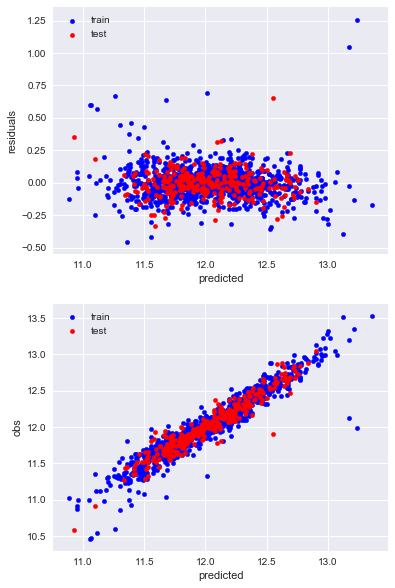

In [16]:
pipe1 = Pipeline([('scale', RobustScaler()),
                  ('ridge', linear_model.RidgeCV(alphas=(10., 20., 30., 40., 50.)))])
pipe1.fit(housing_train, lprices_train) 
perf_test(pipe1)
pipe1.named_steps['ridge'].alpha_

{'n_estimators': 400}
train score: 0.040, test score: 0.102
[0.11990247 0.13419251 0.13127752 0.11785058 0.12620455]


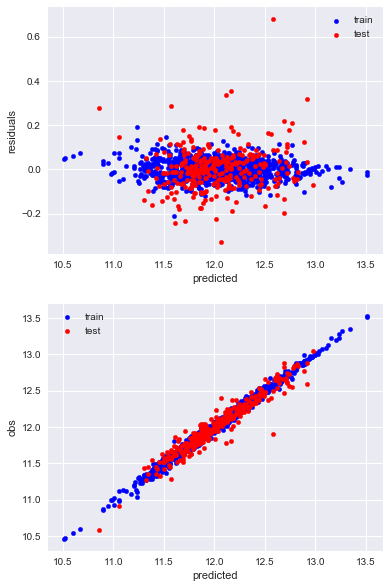

In [17]:
params = {'n_estimators': [300, 400, 500, 600]}
clf = GridSearchCV(ensemble.GradientBoostingRegressor(), params, 
                   cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
clf.fit(housing_train, lprices_train)
print(clf.best_params_)
perf_test(clf.best_estimator_)

# Submission

In [18]:
ridge_pred = pipe1.predict(test_prep)
gb_pred = clf.best_estimator_.predict(test_prep)
pred = np.exp(ridge_pred) * 0.7 + np.exp(gb_pred) * 0.3
results = pd.DataFrame({'Id': test.Id, 'SalePrice': pred})
results.to_csv(HOUSING_DATA_PATH / 'submission.csv', index=False)
results.head()

,Id,SalePrice
0,1461,115420.406246
1,1462,134199.035080
2,1463,174616.297079
3,1464,195371.199399
4,1465,193926.238018
